In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import MiniPole code

#classes to calculate synthetic data, not needed if you have your data available
from mini_pole import GreenFunc
from mini_pole.spectrum_example import *

#class to perform real-frequency fitting
from mini_pole import MiniPoleRf

# 0. Tools

In [3]:
# calculate the Green's function from its complex poles
def cal_G(z, Al, xl):
    G_z = 0.0
    for i in range(xl.size):
        G_z += Al[[i]] / (z.reshape(-1, 1) - xl[i])
    return G_z

In [4]:
# Hilbert transform of a Gaussian function
from scipy.special import dawsn
def hilbert_gaussian(w, mu = 0.0, sigma = 1.0):
    return np.sqrt(2) / (np.pi * sigma) * dawsn((w - mu) / (np.sqrt(2) * sigma))

In [5]:
# given an instance of the MiniPoleRf class p and a list of M, obtain the comlpex pole results
def obt_pol(p, M_list, matrix=False):
    Al_list = []
    xl_list = []
    for M in M_list:
        p.change_M(M)
        if matrix is False:
            Al_list.append(p.pole_weight.reshape(-1, 1))
            xl_list.append(p.pole_location)
        else:
            Al_list.append(p.pole_weight.reshape(-1, 4))
            xl_list.append(p.pole_location)
    return Al_list, xl_list

In [6]:
# compute the recovered density of states and Green's function, along with their deviations from the exact counterparts
def obt_result(Al_list, xl_list, M_list, dos_e, G_R_e, G_w_e):
    dos_r = []
    G_R_r = []
    G_w_r = []
    err_dos_mean = []
    err_dos_max  = []
    err_ret_mean = []
    err_ret_max  = []
    err_Mat_mean = []
    err_Mat_max  = []
    for i in range(len(M_list)):
        Al = Al_list[i]
        xl = xl_list[i]
        dos_r.append(          2 * cal_G(      w, Al, xl).real)
        G_R_r.append(-2j * np.pi * cal_G(      w, Al, xl))
        G_w_r.append(-2j * np.pi * cal_G(1j * wn, Al, xl))
        err_dos_mean.append(np.abs(dos_r[-1] - dos_e).max(axis=1).mean())
        err_dos_max.append( np.abs(dos_r[-1] - dos_e).max(axis=1).max())
        err_ret_mean.append(np.abs(G_R_r[-1].real - G_R_e.real).max(axis=1).mean())
        err_ret_max.append( np.abs(G_R_r[-1].real - G_R_e.real).max(axis=1).max())
        err_Mat_mean.append(np.abs(G_w_r[-1] - G_w_e).max(axis=1).mean())
        err_Mat_max.append( np.abs(G_w_r[-1] - G_w_e).max(axis=1).max())
    return dos_r, G_R_r, G_w_r, err_dos_mean, err_dos_max, err_ret_mean, err_ret_max, err_Mat_mean, err_Mat_max

# list indices of the corresponding results
idx_dos_r = 0
idx_G_R_r = 1
idx_G_w_r = 2
idx_err_dos_mean = 3
idx_err_dos_max  = 4
idx_err_ret_mean = 5
idx_err_ret_max  = 6
idx_err_Mat_mean = 7
idx_err_Mat_max  = 8

# 1. Input function

In [7]:
# density of states
def kondo_dos(w):
    return 0.2 * gaussian(w, -2, 0.5) + 0.6 * lorentzian(w, half_width=0.01) + 0.2 * gaussian(w, 2, 0.5)

# retarded Green's function
def kondo_G_R(w):
    return 0.2 * np.pi * (hilbert_gaussian(w, -2, 0.5) - 1j * gaussian(w, -2, 0.5)) + 0.6 / (w + 0.01j) + 0.2 * np.pi * (hilbert_gaussian(w, 2, 0.5) - 1j * gaussian(w, 2, 0.5))

In [8]:
# density of states for diagonal elements
def boson_dos_diag(w):
    return -0.6 * gaussian(w, -1.2, 0.8) + 0.6 * gaussian(w, 1.2, 0.8)

# density of states for off-diagonal elements
def boson_dos_offdiag(w):
    return -0.13 * gaussian(w, -1.8, 0.5) + 0.1 * gaussian(w, -1.0, 1.0) - 0.1 * gaussian(w, 1.0, 1.0) + 0.13 * gaussian(w, 1.8, 0.5)

# retarded Green's function for diagonal elements
def boson_G_R_diag(w):
    return -0.6 * np.pi * (hilbert_gaussian(w, -1.2, 0.8) - 1j * gaussian(w, -1.2, 0.8)) + 0.6 * np.pi * (hilbert_gaussian(w, 1.2, 0.8) - 1j * gaussian(w, 1.2, 0.8))

# retarded Green's function for off-diagonal elements
def boson_G_R_offdiag(w):
    return - 0.13 * np.pi * (hilbert_gaussian(w, -1.8, 0.5) - 1j * gaussian(w, -1.8, 0.5)) \
           + 0.10 * np.pi * (hilbert_gaussian(w, -1.0, 1.0) - 1j * gaussian(w, -1.0, 1.0)) \
           - 0.10 * np.pi * (hilbert_gaussian(w,  1.0, 1.0) - 1j * gaussian(w,  1.0, 1.0)) \
           + 0.13 * np.pi * (hilbert_gaussian(w,  1.8, 0.5) - 1j * gaussian(w,  1.8, 0.5))

# 2. Exact results

In [9]:
w = np.linspace(-10, 10, 100000)
wn = np.linspace(0, 100, 10000)
# density of states
dos_e1 = kondo_dos(w).reshape(-1, 1)
dos_e2_diag = boson_dos_diag(w); dos_e2_offdiag = boson_dos_offdiag(w)
dos_e2 = np.array([dos_e2_diag, dos_e2_offdiag, dos_e2_offdiag, dos_e2_diag]).T.reshape(-1, 4)
# retarded Green's function
G_R_e1 = kondo_G_R(w).reshape(-1, 1)
G_R_e2_diag = boson_G_R_diag(w); G_R_e2_offdiag = boson_G_R_offdiag(w)
G_R_e2 = np.array([G_R_e2_diag, G_R_e2_offdiag, G_R_e2_offdiag, G_R_e2_diag]).T.reshape(-1, 4)
# Matsubara Green's function
gf = GreenFunc("F", 1, "continuous", A_x= lambda w: 0.2 * gaussian(w, -2, 0.5) + 0.2 * gaussian(w, 2, 0.5), x_min=-np.inf, x_max=np.inf)
G_w_e1 = (gf.get_G(1j * wn) + 0.6 / (1j * wn + 0.01j)).reshape(-1, 1)
gf_diag    = GreenFunc("F", 1, "continuous", A_x=boson_dos_diag   , x_min=-np.inf, x_max=np.inf)
gf_offdiag = GreenFunc("F", 1, "continuous", A_x=boson_dos_offdiag, x_min=-np.inf, x_max=np.inf)
G_w_e2_diag = gf_diag.get_G(1j * wn); G_w_e2_offdiag = gf_offdiag.get_G(1j * wn)
G_w_e2 = np.array([G_w_e2_diag, G_w_e2_offdiag, G_w_e2_offdiag, G_w_e2_diag]).T.reshape(-1, 4)

# 3. MPM results

In [10]:
# obtain results where the final approximation is accurate to within 1.e-12
p1 = MiniPoleRf([kondo_dos], interval_type="infinite", wp_max=2, err=1.e-12, k_max=3000)
p2 = MiniPoleRf([boson_dos_diag, boson_dos_offdiag, boson_dos_offdiag, boson_dos_diag], interval_type="infinite", wp_max=2, err=1.e-12, k_max=3000)

In [11]:
# obtain results for different values of M using p.change_M(M). Note that the contour integrals h_k can be reused.
M_list1 = np.arange(3, 20, 2)
M_list2 = np.arange(3, 20, 2)

Al_list1, xl_list1 = obt_pol(p1, M_list1)
Al_list2, xl_list2 = obt_pol(p2, M_list2, matrix=True)

In [12]:
# recover the Green's functions and their associated errors
r1 = obt_result(Al_list1, xl_list1, M_list1, dos_e1, G_R_e1, G_w_e1)
r2 = obt_result(Al_list2, xl_list2, M_list2, dos_e2, G_R_e2, G_w_e2)

# 4. Plot

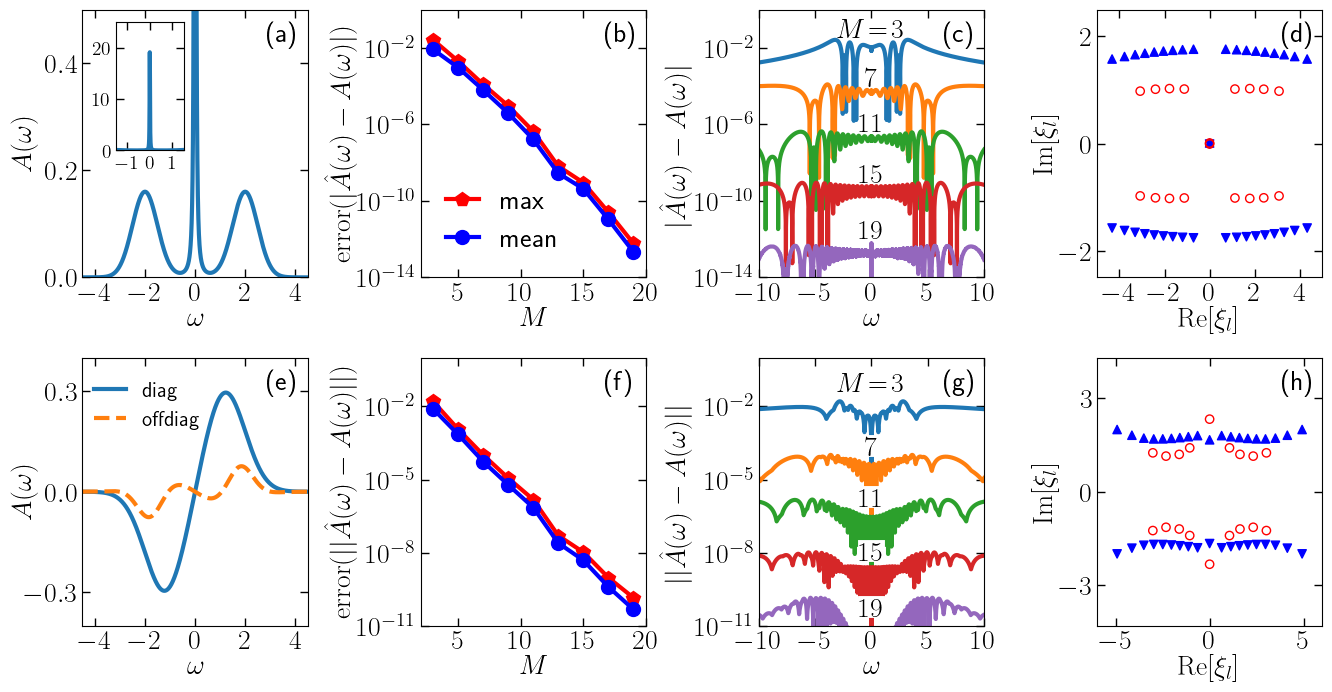

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
plt.rcParams.update({
    'text.usetex': True,
    'font.weight': 'bold',  # Makes the font bold
    'axes.labelweight': 'bold',  # Axis labels bold
    'axes.titleweight': 'bold'   # Title bold
})
colors  = [(1, 1, 1), (0, 0, 1)] #(R, G, B) tuples for white and blue
colors2 = [(1, 1, 1), (1, 0, 0)] #(R, G, B) tuples for white and red
n_bins = 100 #Discretize the interpolation into bins
cmap_name  = "WtBu"
cmap  = LinearSegmentedColormap.from_list(cmap_name , colors , N=n_bins) #Create the colormap

fontsize = 20
labelsize = 20
linewidth = 3
markersize= 10

major_len = 6
major_wid = 1
minor_len = 3
minor_wid = 1

# Create the figure and subplots
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 4, wspace=0.5, hspace=0.3)
(axs0, axs1) = gs.subplots()

# Plot data in the subplots
# Subplot (a)
axs0[0].plot(w, dos_e1, color="tab:blue", linestyle = "-", linewidth=linewidth, label = "Exact")
axs0[0].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs0[0].tick_params(which="major", length=major_len, width=major_wid)
axs0[0].tick_params(which="minor", length=minor_len, width=minor_wid)
axs0[0].set_xticks([-4, -2, 0, 2, 4])
axs0[0].set_xlim([-4.5, 4.5])
axs0[0].set_ylim([0, 0.5])
axs0[0].set_xlabel(r"$\omega$", labelpad=0, fontsize=fontsize)
axs0[0].set_ylabel(r"$A(\omega)$", labelpad=5, fontsize=fontsize)
axs0[0].annotate("(a)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

axins0 = inset_axes(axs0[0], width="100%", height="100%", bbox_to_anchor=(.18, .5, .3, .48), bbox_transform=axs0[0].transAxes)
axins0.plot(w, dos_e1, color="tab:blue", linestyle = "-", linewidth=linewidth, label = "Exact")
axins0.tick_params(axis="both", which="both", direction="in", labelsize=labelsize-6, right=True, top=True)
axins0.tick_params(which="major", length=major_len, width=major_wid)
axins0.tick_params(which="minor", length=minor_len, width=minor_wid)
axins0.set_xticks([-1, 0, 1])
axins0.set_yticks([0, 10, 20, 30])
axins0.set_xlim([-1.5, 1.5])
axins0.set_ylim([0, 25])

# Subplot (b)
axs0[1].semilogy(M_list1, r1[idx_err_dos_max] , color="red" , linestyle = "-", linewidth=linewidth, marker="p", markersize=markersize, label="max")
axs0[1].semilogy(M_list1, r1[idx_err_dos_mean], color="blue", linestyle = "-", linewidth=linewidth, marker="o", markersize=markersize, label="mean")
axs0[1].legend(fontsize=fontsize, frameon=False, handlelength=1.2)
axs0[1].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs0[1].tick_params(which="major", length=major_len, width=major_wid)
axs0[1].tick_params(which="minor", length=minor_len, width=minor_wid)
axs0[1].set_xticks([0, 5, 10, 15, 20])
axs0[1].set_xlim([2, 20])
axs0[1].set_ylim([1e-14, 1e-0])
axs0[1].set_xlabel(r"$M$", labelpad=0, fontsize=fontsize)
axs0[1].set_ylabel(r"${\rm error}(|\hat{A}(\omega) - A(\omega)|)$", labelpad=0, fontsize=fontsize)
axs0[1].annotate("(b)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

# Subplot (c)
for i in range(0, len(M_list1), 2):
    axs0[2].semilogy(w, np.abs(r1[idx_dos_r][i] - dos_e1), linestyle = "-", linewidth=linewidth)
axs0[2].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs0[2].tick_params(which="major", length=major_len, width=major_wid)
axs0[2].tick_params(which="minor", length=minor_len, width=minor_wid)
axs0[2].set_xticks([-10, -5, 0, 5, 10])
axs0[2].set_xlim([-10, 10])
axs0[2].set_ylim([1e-14, 1e0])
axs0[2].set_xlabel(r"$\omega$", labelpad=0, fontsize=fontsize)
axs0[2].set_ylabel(r"$|\hat{A}(\omega) - A(\omega)|$", labelpad=2, fontsize=fontsize)
axs0[2].annotate("(c)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)
axs0[2].annotate(r"$M\!=\!3$", (0.5, 0.92), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[2].annotate(r"$7$",       (0.5, 0.74), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[2].annotate(r"$11$",      (0.5, 0.57), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[2].annotate(r"$15$",      (0.5, 0.38), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[2].annotate(r"$19$",      (0.5, 0.17), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)

# Subplot (d)
scatter0 = axs0[3].scatter(xl_list1[-1].real,  xl_list1[-1].imag, c=np.ones(Al_list1[-1].shape), vmin=0, vmax=1, cmap=cmap, marker="v")
scatter0 = axs0[3].scatter(xl_list1[-1].real, -xl_list1[-1].imag, c=np.ones(Al_list1[-1].shape), vmin=0, vmax=1, cmap=cmap, marker="^")
scatter0 = axs0[3].scatter(xl_list1[3].real ,  xl_list1[3].imag , facecolors="none", edgecolors="red", marker="o")
scatter0 = axs0[3].scatter(xl_list1[3].real , -xl_list1[3].imag , facecolors="none", edgecolors="red", marker="o")
axs0[3].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs0[3].tick_params(which="major", length=major_len, width=major_wid)
axs0[3].tick_params(which="minor", length=minor_len, width=minor_wid)
axs0[3].set_xticks([-4, -2, 0, 2, 4])
axs0[3].set_xlim([-5, 5])
axs0[3].set_ylim([-2.5, 2.5])
axs0[3].set_xlabel(r"${\rm Re}[\xi_l]$", labelpad=0, fontsize=fontsize)
axs0[3].set_ylabel(r"${\rm Im}[\xi_l]$", labelpad=0, fontsize=fontsize)
axs0[3].annotate("(d)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

# Subplot (e)
axs1[0].plot(w, dos_e2[:, 0], color="tab:blue"  , linestyle = "-" , linewidth=linewidth, label = "diag")
axs1[0].plot(w, dos_e2[:, 1], color="tab:orange", linestyle = "--", linewidth=linewidth, label = "offdiag")
axs1[0].legend(fontsize=fontsize-5, frameon=False, loc="upper left", bbox_to_anchor=(-0.03, 0.98), handlelength=1.5)
axs1[0].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs1[0].tick_params(which="major", length=major_len, width=major_wid)
axs1[0].tick_params(which="minor", length=minor_len, width=minor_wid)
axs1[0].set_xticks([-4, -2, 0, 2, 4])
axs1[0].set_yticks([-0.3, 0, 0.3])
axs1[0].set_xlim([-4.5, 4.5])
axs1[0].set_ylim([-0.4, 0.4])
axs1[0].set_xlabel(r"$\omega$", labelpad=0, fontsize=fontsize)
axs1[0].set_ylabel(r"$A(\omega)$", labelpad=-10, fontsize=fontsize)
axs1[0].annotate("(e)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

# Subplot (f)
axs1[1].semilogy(M_list2, r2[idx_err_dos_max] , color="red" , linestyle = "-", linewidth=linewidth, marker="p", markersize=markersize, label="max")
axs1[1].semilogy(M_list2, r2[idx_err_dos_mean], color="blue", linestyle = "-", linewidth=linewidth, marker="o", markersize=markersize, label="mean")
axs1[1].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs1[1].tick_params(which="major", length=major_len, width=major_wid)
axs1[1].tick_params(which="minor", length=minor_len, width=minor_wid)
axs1[1].set_xticks([0, 5, 10, 15, 20])
axs1[1].set_xlim([2, 20])
axs1[1].set_ylim([1e-11, 1e-0])
axs1[1].set_xlabel(r"$M$", labelpad=0, fontsize=fontsize)
axs1[1].set_ylabel(r"${\rm error}(||\hat{A}(\omega) - A(\omega)||)$", labelpad=0, fontsize=fontsize)
axs1[1].annotate("(f)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

# Subplot (g)
for i in range(0, len(M_list2), 2):
    axs1[2].semilogy(w, np.abs(r2[idx_dos_r][i] - dos_e2).max(axis=1), linestyle = "-", linewidth=linewidth)
axs1[2].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs1[2].tick_params(which="major", length=major_len, width=major_wid)
axs1[2].tick_params(which="minor", length=minor_len, width=minor_wid)
axs1[2].set_xticks([-10, -5, 0, 5, 10])
axs1[2].set_xlim([-10, 10])
axs1[2].set_ylim([1e-11, 1e-0])
axs1[2].set_xlabel(r"$\omega$", labelpad=0, fontsize=fontsize)
axs1[2].set_ylabel(r"$||\hat{A}(\omega) - A(\omega)||$", labelpad=2, fontsize=fontsize)
axs1[2].annotate("(g)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)
rect1 = patches.Rectangle((0.47, 0.655), 0.06, 0.03, transform=axs1[2].transAxes, linewidth=10, edgecolor='white', facecolor='white', zorder=2)
rect2 = patches.Rectangle((0.47, 0.465), 0.06, 0.03, transform=axs1[2].transAxes, linewidth=10, edgecolor='white', facecolor='white', zorder=2)
rect3 = patches.Rectangle((0.47, 0.265), 0.06, 0.03, transform=axs1[2].transAxes, linewidth=10, edgecolor='white', facecolor='white', zorder=2)
rect4 = patches.Rectangle((0.47, 0.055), 0.06, 0.03, transform=axs1[2].transAxes, linewidth=10, edgecolor='white', facecolor='white', zorder=2)
axs1[2].add_patch(rect1)
axs1[2].add_patch(rect2)
axs1[2].add_patch(rect3)
axs1[2].add_patch(rect4)
axs1[2].annotate(r"$M\!=\!" + str(M_list2[0]) + "$", (0.5, 0.90), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[2].annotate(r"$"       + str(M_list2[2]) + "$", (0.5, 0.66), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[2].annotate(r"$"       + str(M_list2[4]) + "$", (0.5, 0.47), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[2].annotate(r"$"       + str(M_list2[6]) + "$", (0.5, 0.27), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[2].annotate(r"$"       + str(M_list2[8]) + "$", (0.5, 0.06), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)

# Subplot (h)
scatter1 = axs1[3].scatter(xl_list2[-1].real,  xl_list2[-1].imag, c=np.ones(xl_list2[-1].shape), vmin=0, vmax=1, cmap=cmap, marker="v")
scatter1 = axs1[3].scatter(xl_list2[-1].real, -xl_list2[-1].imag, c=np.ones(xl_list2[-1].shape), vmin=0, vmax=1, cmap=cmap, marker="^")
scatter1 = axs1[3].scatter(xl_list2[3].real ,  xl_list2[3].imag , facecolors="none", edgecolors="red", marker="o")
scatter1 = axs1[3].scatter(xl_list2[3].real , -xl_list2[3].imag , facecolors="none", edgecolors="red", marker="o")
axs1[3].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs1[3].tick_params(which="major", length=major_len, width=major_wid)
axs1[3].tick_params(which="minor", length=minor_len, width=minor_wid)
axs1[3].set_xticks([-5, 0, 5])
axs1[3].set_yticks([-3, 0, 3])
axs1[3].set_xlim([-6, 6])
axs1[3].set_ylim([-4.3, 4.3])
axs1[3].set_xlabel(r"${\rm Re}[\xi_l]$", labelpad=0, fontsize=fontsize)
axs1[3].set_ylabel(r"${\rm Im}[\xi_l]$", labelpad=0, fontsize=fontsize)
axs1[3].annotate("(h)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

plt.show()

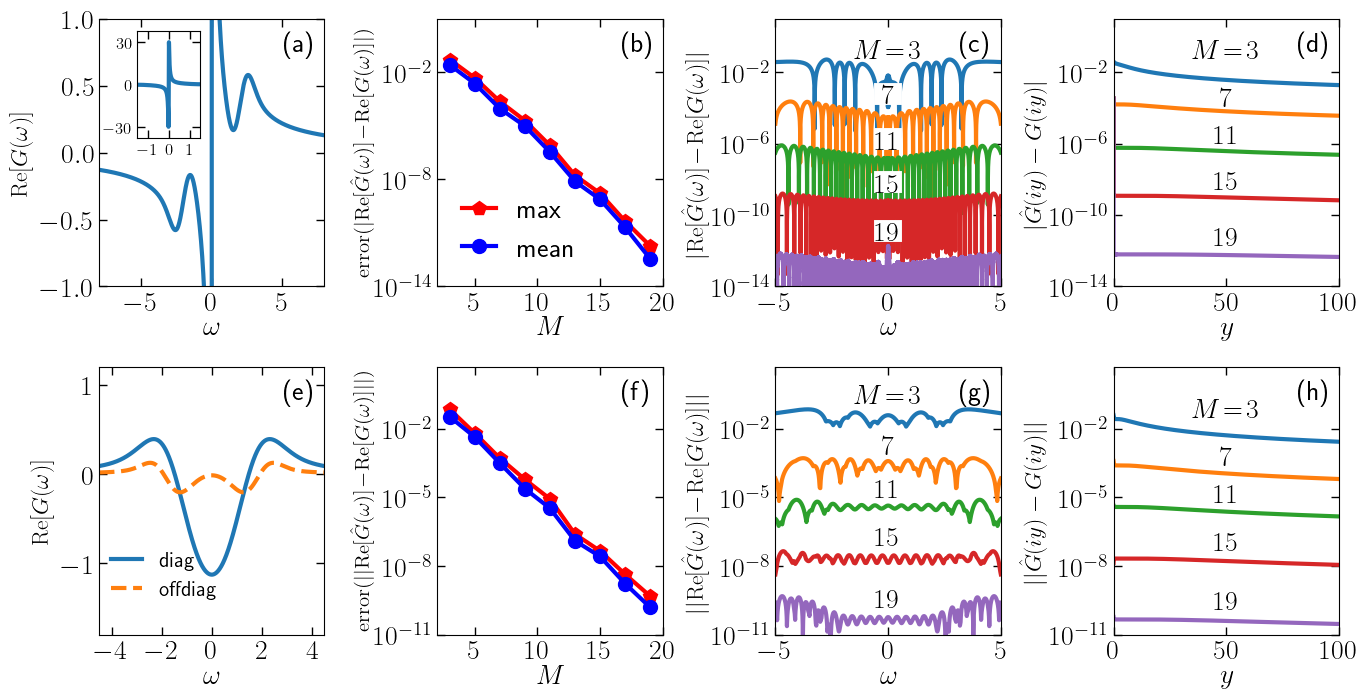

In [14]:
# Create the figure and subplots
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 4, wspace=0.5, hspace=0.3)
(axs0, axs1) = gs.subplots()

# Plot data in the subplots
# Subplot (a)
axs0[0].plot(w, G_R_e1.real, color="tab:blue", linestyle = "-", linewidth=linewidth, label = "Exact")
axs0[0].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs0[0].tick_params(which="major", length=major_len, width=major_wid)
axs0[0].tick_params(which="minor", length=minor_len, width=minor_wid)
axs0[0].set_xticks([-5, 0, 5])
axs0[0].set_xlim([-8, 8])
axs0[0].set_ylim([-1, 1])
axs0[0].set_xlabel(r"$\omega$", labelpad=0, fontsize=fontsize)
axs0[0].set_ylabel(r"${\rm Re}[G(\omega)]$", labelpad=5, fontsize=fontsize-3)
axs0[0].annotate("(a)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

axins = inset_axes(axs0[0], width="100%", height="100%", bbox_to_anchor=(.2, .58, .28, .4), bbox_transform=axs0[0].transAxes)
axins.plot(w, G_R_e1.real, color="tab:blue", linestyle = "-", linewidth=linewidth, label = "Exact")
axins.tick_params(axis="both", which="both", direction="in", labelsize=labelsize-8, right=True, top=True)
axins.tick_params(which="major", length=major_len, width=major_wid)
axins.tick_params(which="minor", length=minor_len, width=minor_wid)
axins.set_xticks([-1, 0, 1])
axins.set_yticks([-30, 0, 30])
axins.set_xlim([-1.5, 1.5])
axins.set_ylim([-38, 38])

# Subplot (b)
axs0[1].semilogy(M_list1, r1[idx_err_ret_max] , color="red" , linestyle = "-", linewidth=linewidth, marker="p", markersize=markersize, label="max")
axs0[1].semilogy(M_list1, r1[idx_err_ret_mean], color="blue", linestyle = "-", linewidth=linewidth, marker="o", markersize=markersize, label="mean")
axs0[1].legend(fontsize=fontsize, frameon=False, handlelength=1.2)
axs0[1].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs0[1].tick_params(which="major", length=major_len, width=major_wid)
axs0[1].tick_params(which="minor", length=minor_len, width=minor_wid)
axs0[1].set_xticks([0, 5, 10, 15, 20])
axs0[1].set_yticks([1.e-2, 1.e-8, 1.e-14])
axs0[1].set_xlim([2, 20])
axs0[1].set_ylim([1e-14, 1e1])
axs0[1].set_xlabel(r"$M$", labelpad=0, fontsize=fontsize)
axs0[1].set_ylabel(r"${\rm error}(|{\rm Re}[\hat{G}(\omega)] \! - \! {\rm Re}[G(\omega)]|)$", labelpad=0, fontsize=fontsize-5)
axs0[1].annotate("(b)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

# Subplot (c)
for i in range(0, len(M_list1), 2):
    axs0[2].semilogy(w, np.abs(r1[idx_G_R_r][i].real - G_R_e1.real), linestyle = "-", linewidth=linewidth)
axs0[2].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs0[2].tick_params(which="major", length=major_len, width=major_wid)
axs0[2].tick_params(which="minor", length=minor_len, width=minor_wid)
axs0[2].set_xticks([-10, -5, 0, 5, 10])
axs0[2].set_xlim([-5, 5])
axs0[2].set_ylim([1e-14, 1e1])
axs0[2].set_xlabel(r"$\omega$", labelpad=0, fontsize=fontsize)
axs0[2].set_ylabel(r"$|{\rm Re}[\hat{G}(\omega)] \! - \! {\rm Re}[G(\omega)]|$", labelpad=2, fontsize=fontsize-3)
axs0[2].annotate("(c)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)
rect1 = patches.Rectangle((0.47, 0.705), 0.06, 0.03, transform=axs0[2].transAxes, linewidth=10, edgecolor='white', facecolor='white', zorder=2)
rect2 = patches.Rectangle((0.47, 0.535), 0.06, 0.03, transform=axs0[2].transAxes, linewidth=10, edgecolor='white', facecolor='white', zorder=2)
rect3 = patches.Rectangle((0.47, 0.375), 0.06, 0.03, transform=axs0[2].transAxes, linewidth=10, edgecolor='white', facecolor='white', zorder=2)
rect4 = patches.Rectangle((0.47, 0.193), 0.06, 0.03, transform=axs0[2].transAxes, linewidth=10, edgecolor='white', facecolor='white', zorder=2)
axs0[2].add_patch(rect1)
axs0[2].add_patch(rect2)
axs0[2].add_patch(rect3)
axs0[2].add_patch(rect4)
axs0[2].annotate(r"$M\!=\!" + str(M_list1[0]) + "$", (0.5, 0.88), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[2].annotate(r"$"       + str(M_list1[2]) + "$", (0.5, 0.71), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[2].annotate(r"$"       + str(M_list1[4]) + "$", (0.5, 0.54), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[2].annotate(r"$"       + str(M_list1[6]) + "$", (0.5, 0.38), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[2].annotate(r"$"       + str(M_list1[8]) + "$", (0.5, 0.20), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)

# Subplot (d)
for i in range(0, len(M_list1), 2):
    axs0[3].semilogy(wn, np.abs(r1[idx_G_w_r][i] - G_w_e1), linestyle = "-", linewidth=linewidth)
axs0[3].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs0[3].tick_params(which="major", length=major_len, width=major_wid)
axs0[3].tick_params(which="minor", length=minor_len, width=minor_wid)
axs0[3].set_xlim([0, 100])
axs0[3].set_ylim([1e-14, 1e1])
axs0[3].set_xlabel(r"$y$", labelpad=0, fontsize=fontsize)
axs0[3].set_ylabel(r"$|\hat{G}(iy) - G(iy)|$", labelpad=2, fontsize=fontsize-3)
axs0[3].annotate("(d)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)
axs0[3].annotate(r"$M\!=\!" + str(M_list1[0]) + "$", (0.5, 0.88), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[3].annotate(r"$"       + str(M_list1[2]) + "$", (0.5, 0.70), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[3].annotate(r"$"       + str(M_list1[4]) + "$", (0.5, 0.56), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[3].annotate(r"$"       + str(M_list1[6]) + "$", (0.5, 0.39), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs0[3].annotate(r"$"       + str(M_list1[8]) + "$", (0.5, 0.18), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)

# Subplot (e)
axs1[0].plot(w, G_R_e2[:, 0].real, color="tab:blue"  , linestyle = "-" , linewidth=linewidth, label = "diag")
axs1[0].plot(w, G_R_e2[:, 1].real, color="tab:orange", linestyle = "--", linewidth=linewidth, label = "offdiag")
axs1[0].legend(fontsize=fontsize-5, frameon=False, loc="upper left", bbox_to_anchor=(-0.03, 0.38), handlelength=1.5)
axs1[0].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs1[0].tick_params(which="major", length=major_len, width=major_wid)
axs1[0].tick_params(which="minor", length=minor_len, width=minor_wid)
axs1[0].set_xticks([-4, -2, 0, 2, 4])
axs1[0].set_xlim([-4.5, 4.5])
axs1[0].set_ylim([-1.8, 1.2])
axs1[0].set_xlabel(r"$\omega$", labelpad=0, fontsize=fontsize)
axs1[0].set_ylabel(r"${\rm Re}[G(\omega)]$", labelpad=5, fontsize=fontsize-3)
axs1[0].annotate("(e)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

# Subplot (f)
axs1[1].semilogy(M_list2, r2[idx_err_ret_max] , color="red" , linestyle = "-", linewidth=linewidth, marker="p", markersize=markersize, label="max")
axs1[1].semilogy(M_list2, r2[idx_err_ret_mean], color="blue", linestyle = "-", linewidth=linewidth, marker="o", markersize=markersize, label="mean")
axs1[1].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs1[1].tick_params(which="major", length=major_len, width=major_wid)
axs1[1].tick_params(which="minor", length=minor_len, width=minor_wid)
axs1[1].set_xticks([0, 5, 10, 15, 20])
axs1[1].set_yticks([1.e-2, 1.e-5, 1.e-8, 1.e-11])
axs1[1].set_xlim([2, 20])
axs1[1].set_ylim([1e-11, 5e0])
axs1[1].set_xlabel(r"$M$", labelpad=0, fontsize=fontsize)
axs1[1].set_ylabel(r"${\rm error}(||{\rm Re}[\hat{G}(\omega)] \! - \! {\rm Re}[G(\omega)]||)$", labelpad=0, fontsize=fontsize-5)
axs1[1].annotate("(f)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)

# Subplot (g)
for i in range(0, len(M_list2), 2):
    axs1[2].semilogy(w, np.abs(r2[idx_G_R_r][i].real - G_R_e2.real).max(axis=1), linestyle = "-", linewidth=linewidth)
axs1[2].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs1[2].tick_params(which="major", length=major_len, width=major_wid)
axs1[2].tick_params(which="minor", length=minor_len, width=minor_wid)
axs1[2].set_xticks([-10, -5, 0, 5, 10])
axs1[2].set_yticks([1.e-2, 1.e-5, 1.e-8, 1.e-11])
axs1[2].set_xlim([-5, 5])
axs1[2].set_ylim([1e-11, 5e0])
axs1[2].set_xlabel(r"$\omega$", labelpad=0, fontsize=fontsize)
axs1[2].set_ylabel(r"$||{\rm Re}[\hat{G}(\omega)] \! - \! {\rm Re}[G(\omega)]||$", labelpad=2, fontsize=fontsize-3)
axs1[2].annotate("(g)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)
axs1[2].annotate(r"$M\!=\!" + str(M_list2[0]) + "$", (0.5, 0.89), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[2].annotate(r"$"       + str(M_list2[2]) + "$", (0.5, 0.70), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[2].annotate(r"$"       + str(M_list2[4]) + "$", (0.5, 0.54), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[2].annotate(r"$"       + str(M_list2[6]) + "$", (0.5, 0.36), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[2].annotate(r"$"       + str(M_list2[8]) + "$", (0.5, 0.13), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)

# Subplot (h)
for i in range(0, len(M_list2), 2):
    axs1[3].semilogy(wn, np.abs(r2[idx_G_w_r][i] - G_w_e2).max(axis=1), linestyle = "-", linewidth=linewidth)
axs1[3].tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
axs1[3].tick_params(which="major", length=major_len, width=major_wid)
axs1[3].tick_params(which="minor", length=minor_len, width=minor_wid)
axs1[3].set_yticks([1.e-2, 1.e-5, 1.e-8, 1.e-11])
axs1[3].set_xlim([0, 100])
axs1[3].set_ylim([1e-11, 5e0])
axs1[3].set_xlabel(r"$y$", labelpad=0, fontsize=fontsize)
axs1[3].set_ylabel(r"$||\hat{G}(iy) - G(iy)||$", labelpad=2, fontsize=fontsize-3)
axs1[3].annotate("(h)", (0.82, 0.88), xycoords='axes fraction', fontsize=fontsize)
axs1[3].annotate(r"$M\!=\!" + str(M_list2[0]) + "$", (0.5, 0.84), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[3].annotate(r"$"       + str(M_list2[2]) + "$", (0.5, 0.66), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[3].annotate(r"$"       + str(M_list2[4]) + "$", (0.5, 0.52), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[3].annotate(r"$"       + str(M_list2[6]) + "$", (0.5, 0.34), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)
axs1[3].annotate(r"$"       + str(M_list2[8]) + "$", (0.5, 0.12), xycoords='axes fraction', ha="center", va="center", fontsize=fontsize)

plt.show()